In [1]:
__author__ = 'Robert Nikutta <robert.nikutta@noirlab.edu>'
__version__ = '20240606' # yyyymmdd
__datasets__ = ['gogreen_dr1']
__keywords__ = ['image cutout', 'SIA']

# GOGREEN DR1 at Data Lab - Simple Image Access (SIA)

*Author:* Robert Nikutta \<robert.nikutta@noirlab.edu\>

This notebook demonstrates how the GOGREEN DR1 images can be queried for at Data Lab using the SIA service, and how cutouts around positions on the sky can be retrieved.

# Table of contents
* [Disclaimer & attribution](#disclaimer)
* [Imports, setup, & SIA config](#imports)
* [Family picture of a cluster](#family)
  * [Query the clusters catalog for information using TAP](#query-clusters)
  * [Run a SIA query](#sia1)
  * [Download an image](#image)
  * [Plot the image](#plot-image)
* [Gallery of cluster members](#gallery)
  * [Query the photometry table for cluster member data](#query-photometry)
  * [Calling the SIA service for individual cutouts](#sia2)
  * [Plotting a gallery of thumbnails](#plot-gallery)

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="imports"></a>
# Imports, setup and SIA config

In [2]:
# 3rd party
import numpy as np
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib
from matplotlib.ticker import NullFormatter, NullLocator
import pylab as plt
plt.rcParams.update({'font.size': 16})

from pyvo.dal import sia
# this URL tells the SIA service where to find images and image metadata
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/gogreen_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

# Data Lab
from dl import queryClient as qc

<a class="anchor" id="family"></a>
# Family picture of a cluster

The SIA service can be used to query the database of meta-information about images served by the cutout service. Often the metadata are in varying degrees of completeness or correctness, but we can usually make sense of it.

<a class="anchor" id="query-clusters"></a>
## Query the clusters catalog for information using TAP 

Let's first query the TAP service (Table Access Protocol) for information about clusters. This can be accomplished by issuing SQL queries with the Data Lab `queryClient` (imported as `qc`):

In [3]:
df = qc.query("select * from gogreen_dr1.clusters",fmt='pandas')
print("Shape:", df.shape)
print("Columns:", df.columns)
df.head(10)

Shape: (26, 39)
Columns: Index(['cluster', 'fullname', 'cluster_id', 'ra_best', 'dec_best', 'ra_gmos',
       'dec_gmos', 'pa_deg', 'redshift', 'vdisp', 'vdisp_err', 'gogreen_m1',
       'gogreen_m2', 'gogreen_m3', 'gogreen_m4', 'gogreen_m5', 'gogreen_m6',
       'gclass_m1', 'gclass_m2', 'gclass_m3', 'gclass_m4', 'gclass_m5',
       'kphot_cat', 'photoz_cat', 'stelmass_cat', 'image_u', 'image_b',
       'image_g', 'image_v', 'image_r', 'image_i', 'image_z', 'image_j',
       'image_j1', 'image_y', 'image_k', 'image_irac1', 'preimage',
       'random_id'],
      dtype='object')


,cluster,fullname,cluster_id,ra_best,dec_best,ra_gmos,dec_gmos,pa_deg,redshift,vdisp,...,image_r,image_i,image_z,image_j,image_j1,image_y,image_k,image_irac1,preimage,random_id
0,COSMOS-125,COSMOS-125,14,150.6208,2.1675,150.62720,2.159200,270.0,1.40400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-125_pseudo,82.235855
1,COSMOS-221,COSMOS-221,14,150.5620,2.5031,150.57020,2.498600,90.0,1.19600,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-221_pseudo,16.224028
2,COSMOS-28,COSMOS-28,14,149.4692,1.6685,149.45930,1.675030,78.0,1.31600,285.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-28_pseud,14.708872
3,COSMOS-63,COSMOS-63,14,150.3590,1.9352,150.36147,1.928342,165.0,1.17220,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMICOSMOS-63_pseudo,10.737590
4,SPT0205,SPT-CL J0205-5829,1,31.4510,-58.4803,31.43896,-58.482900,90.0,1.32270,678.0,...,mos_VIMOSR_3,mos_VIMOSI_3,mos_VIMOSz_3,mos_FOURSTARJ_3,mos_FOURSTARJ1_3,NaN,mos_FOURSTARKs_3,mos_IRAC1_3,mfrgS20140928S0161_add,73.878470
5,SPT0546,SPT-CL J0546-5345,2,86.6403,-53.7610,86.65620,-53.758000,0.0,1.06690,977.0,...,mos_VIMOSR_3,mos_VIMOSI_3,mos_VIMOSz_3,mos_FOURSTARJ_3,mos_FOURSTARJ1_3,NaN,mos_FOURSTARKs_3,mos_IRAC1_3,mfrgS20141001S0139_add,60.786003
6,SPT2106,SPT-CL J2106-5844,3,316.5191,-58.7411,316.51913,-58.741100,100.0,1.13066,1055.0,...,mos_VIMOSR_3,mos_VIMOSI_3,mos_VIMOSz_3,mos_FOURSTARJ_3,mos_FOURSTARJ1_3,NaN,mos_FOURSTARKs_3,mos_IRAC1_3,mfrgS20150411S0405_add,56.566788
7,SXDF49,SXDF49XGG,13,34.4996,-5.0649,34.53706,-5.069708,73.0,1.09100,255.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMISXDF49_pseudo,69.287910
8,SXDF64,SXDF64XGG,13,34.3319,-5.2067,34.32375,-5.171400,180.0,0.91600,530.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMISXDF64_pseudo,54.498220
9,SXDF76,SXDF76XGG,13,34.7461,-5.3041,34.73612,-5.321800,350.0,1.45900,520.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GMISXDF76_pseudo,37.474052


We have requested that the query result be converted on the fly to a Pandas data frame, and we have printed the data frame shape (26 rows = clusters, 39 columns), the column names, and the first 10 rows of the table.

Let's pick one cluster... How about SXDF49 ? (it has index number 7 in the table above):

In [4]:
cluster = df.iloc[7]

<a class="anchor" id="sia1"></a>
## Run a SIA query

Now let's issue a SIA query to fetch information about available images that contain the coordinates of SXDF49:

In [5]:
# select FOV and the RA and Dec center coordinates for the SIA search
fov = 1 # degrees (= 12 arcmin)
ra, dec = cluster.ra_best, cluster.dec_best

# launch the SIA search
#imgTable = svc.search((ra,dec), (fov, fov), verbosity=2).to_table()
imgTable = svc.search((ra,dec), (fov, fov), verbosity=2).to_table().to_pandas()
imgTable

,assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,...,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
0,gogreen_dr1,https://datalab.noirlab.edu/svc/cutout?col=gog...,image/fits,111931,,,3,0,0,2,...,,0,0,,0,,Stack,1900-01-01,,0
1,gogreen_dr1,https://datalab.noirlab.edu/svc/cutout?col=gog...,image/fits,111931,,,3,0,0,2,...,,0,0,,0,,Stack,1900-01-01,,0


Looks like we found two images within 1 degree of the RA & Dec coordinates. Of course we want the row for SXDF49 (which is the first one in the two-row table above).

In [6]:
print(cluster.cluster)  # cluster.cluster has the cluster name
row = imgTable[imgTable['access_url'].astype(str).str.contains(cluster.cluster)]
row

SXDF49


,assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,...,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
0,gogreen_dr1,https://datalab.noirlab.edu/svc/cutout?col=gog...,image/fits,111931,,,3,0,0,2,...,,0,0,,0,,Stack,1900-01-01,,0


<a class="anchor" id="image"></a>
## Download an image

The `access_url` field contains the URL to fetch the FITS image. We can download the file, and extract the data and header information (including the WCS):

In [7]:
url = row['access_url'][0]
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
wcs = WCS(hdu.header)

<a class="anchor" id="plot-image"></a>
## Plot the image

We are ready to plot the image. Because of the high dynamic range, we'll scale the pixel values as an hyperbolic arcsine. We'll overplot the WCS as well.

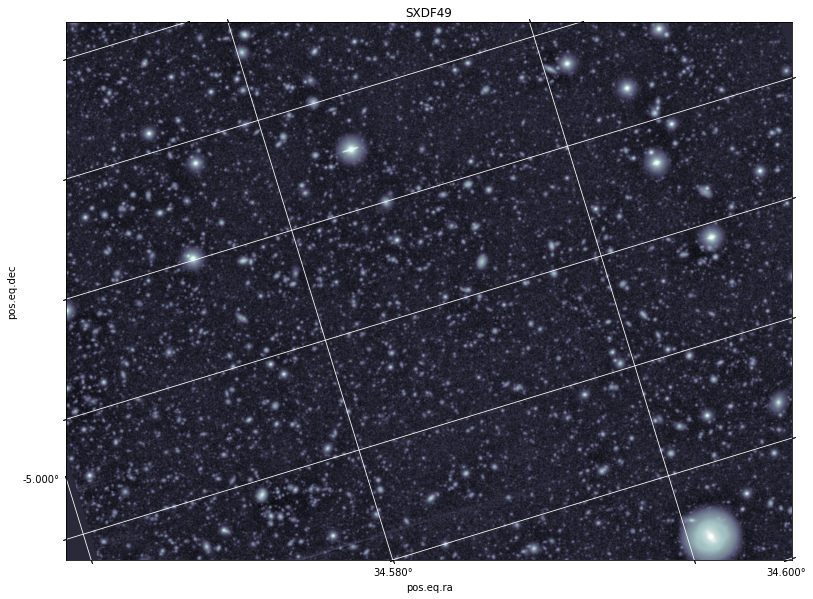

In [8]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection=wcs, label='overlays')
ax.imshow(np.arcsinh(image),origin='lower',cmap='bone')
ax.set_title(cluster.cluster)

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.ddd')
lat.set_major_formatter('d.ddd')

ax.grid(color='white', ls='solid')

<a class="anchor" id="gallery"></a>
# Gallery of cluster members

Using the SIA image cutout service we can request small thumbnails (cutouts) of individual galaxies from a cluster. For this example we will again use cluster SXDF49.

<a class="anchor" id="query-photometry"></a>
## Query the photometry table for cluster member data
Let's first query the photometry catalog for data about members of SXDF49.

In [9]:
dfp = qc.query("select * from gogreen_dr1.photo where cluster='SXDF49' order by cphotid limit 35",fmt='pandas')
dfp.head()

,cluster,cphotid,specid,ra,dec,zspec,redshift_quality,zphot,zphot_l68,zphot_u68,...,eib574_tot,eib709_tot,eib827_tot,efuv_tot,enuv_tot,emips24_tot,htm9,ring256,nest4096,random_id
0,SXDF49,414250073,113083775,34.521161,-5.112165,1.04082,4,1.0485,1.0383,1.0596,...,NaN,NaN,NaN,NaN,NaN,NaN,2144799,427618,72458635,6.786832
1,SXDF49,414250888,113084446,34.503864,-5.110279,1.46743,3,1.3728,1.3605,1.3882,...,NaN,NaN,NaN,NaN,NaN,NaN,2144799,427618,72458656,80.786390
2,SXDF49,414251921,113084961,34.528416,-5.105804,1.00593,4,0.9426,0.9271,0.9581,...,NaN,NaN,NaN,NaN,NaN,NaN,2144799,427618,72458638,35.522877
3,SXDF49,414252096,113085174,34.544271,-5.105723,1.63041,4,1.4935,1.4832,1.5045,...,NaN,NaN,NaN,NaN,NaN,NaN,2144799,427618,72458636,35.795780
4,SXDF49,414252806,113085595,34.556756,-5.103019,1.39074,3,1.4520,1.4330,1.4725,...,NaN,NaN,NaN,NaN,NaN,NaN,2144799,427618,72458637,85.953700


We have asked for the first 35 members of the cluster, after sorting by `cphotid`, and have also asked for the result to be returned as a Pandas data frame.

<a class="anchor" id="sia2"></a>
## Calling the SIA service for individual cutouts
Looping over the resulting table, we can request from the SIA service small cutouts (FOV = 0.005 degrees) around each set of RA & Dec coordinates.

In [10]:
n = dfp.shape[0]
fov = 0.005
images = []
for j in range(n):
    ra, dec = dfp.iloc[j].ra, dfp.iloc[j].dec
    print("Querying object %2d/%d,ra = %8.4f, dec = %8.4f" % (j+1,n,ra,dec))
    imgTable = svc.search((ra,dec), (fov, fov), verbosity=2).to_table()
    sel = (imgTable['prodtype'] != 'wtmap')
    row = imgTable[sel][0]
    url = row['access_url']
    filename = download_file(url,cache=True,show_progress=False,timeout=120)
    hdu = fits.open(filename)[0]
    image = hdu.data
    images.append(image)

Querying object  1/35,ra =  34.5212, dec =  -5.1122
Querying object  2/35,ra =  34.5039, dec =  -5.1103
Querying object  3/35,ra =  34.5284, dec =  -5.1058
Querying object  4/35,ra =  34.5443, dec =  -5.1057
Querying object  5/35,ra =  34.5568, dec =  -5.1030
Querying object  6/35,ra =  34.5050, dec =  -5.1028
Querying object  7/35,ra =  34.5372, dec =  -5.1018
Querying object  8/35,ra =  34.5085, dec =  -5.1007
Querying object  9/35,ra =  34.5076, dec =  -5.0989
Querying object 10/35,ra =  34.5064, dec =  -5.0960
Querying object 11/35,ra =  34.5203, dec =  -5.0932
Querying object 12/35,ra =  34.5164, dec =  -5.0912
Querying object 13/35,ra =  34.5374, dec =  -5.0905
Querying object 14/35,ra =  34.5758, dec =  -5.0897
Querying object 15/35,ra =  34.5068, dec =  -5.0887
Querying object 16/35,ra =  34.5276, dec =  -5.0882
Querying object 17/35,ra =  34.5782, dec =  -5.0879
Querying object 18/35,ra =  34.5751, dec =  -5.0869
Querying object 19/35,ra =  34.5643, dec =  -5.0861
Querying obj

<a class="anchor" id="plot-gallery"></a>
## Plotting a gallery of thumbnails

With the images stored in the `images` list, we can now plot a 7x7 gallery. Above each thumbnail we will print the `cphotid` of the cluster member, and will print the photometric redshift `zphot` within each thumbnail.

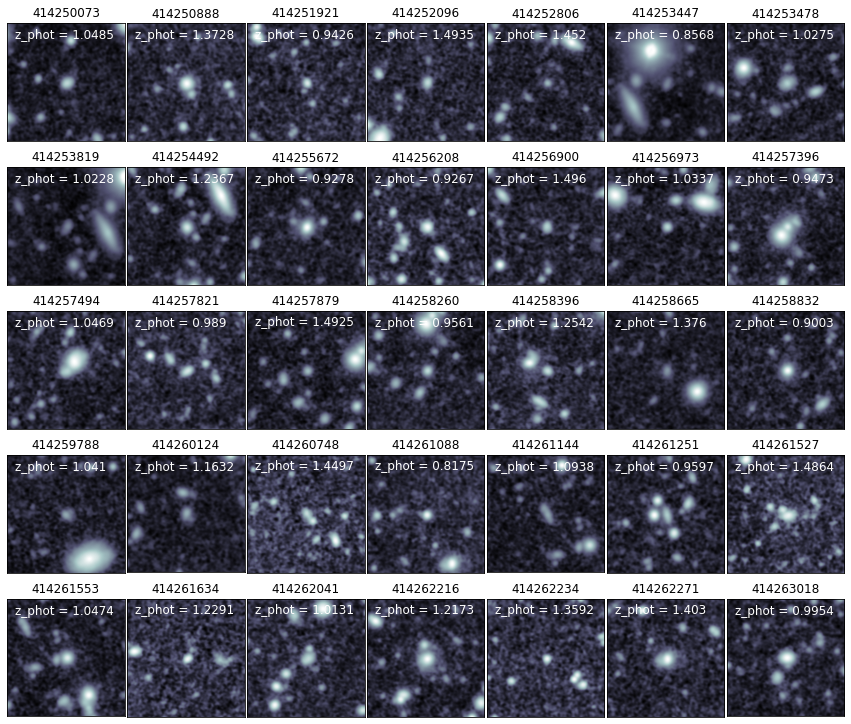

In [11]:
fig = plt.figure(figsize=(15,13))
for j,img in enumerate(images):
    ax = fig.add_subplot(5,7,j+1)
    ax.imshow(np.arcsinh(img.T),origin='lower',cmap='bone')
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.set_title(dfp['cphotid'][j])
    ax.text(0.07,0.87,'z_phot = %g' % dfp.iloc[j]['zphot'],transform=ax.transAxes,color='w',ha='left',fontsize=12)

fig.subplots_adjust(wspace=0.02,hspace=0.1)

In every thumbnail the cluster member with `cphotid` is the object at the center of the image.